# Homograph Study

A great innovation in LLM from first generation language models like GloVe and Word2Vec is that words with multiple meanings can have different representations with in a sentence.  For example a word like "bat" might mean a baseball bat or a flying mammal.

A **homograph** is the technical term for a word with the same spelling but contains multiple meanings.

Lets example we can look at the following GPT-4 embeddings for "bat", "baseball bat" and "flying bat"

### Imports

In [1]:
# !poetry add scikit-learn seaborn

The following packages are already present in the pyproject.toml and will be skipped:

  • scikit-learn
  • seaborn

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [5]:
import pprint
import tqdm
from pydantic import BaseModel, Field

from promptedgraphs.config import Config
from promptedgraphs.ideation import brainstorm
from promptedgraphs.vis import render_entities, get_colors
from itertools import combinations
from promptedgraphs.models import EntityReference
import re
from sklearn.metrics.pairwise import cosine_distances

## Data Model

In [6]:
class Homographs(BaseModel):
    """A homograph is a word with multiple meanings, we show here the word, and two sentences with multiple uses of the word.
    """
    homograph: str = Field(title="A word that is a homograph", example=['bat'])
    example_sentence1: str = Field(title="An example of the homograph used in a unique context", example=['He took a swing with the baseball bat.'] )
    example_sentence2: str = Field(title="A second example of the homograph used in a different context", example=['The bat flew out of the cave at dusk.'])
    context1: str = Field(title="A one word description of the homophone's context in example_sentence1", examples=['sports'])
    context2: str = Field(title="A one word description of the homophone's context in example_sentence2", examples=['animal'])

    def __repr__(self):
        return f"{self.homograph}:\n * {self.context1}: {self.example_sentence1}\n * {self.context2}: {self.example_sentence2}\n"

## Brainstorm Homographs (GPT 3.5 turbo generated examples)

In [7]:
ideas = {}

In [8]:
ittr = tqdm.tqdm()
async for idea in brainstorm(
    text=Homographs.__doc__, 
    output_type=list[Homographs], 
    config=Config(),
    n=40,
    max_workers=2,
    temperature=0.5
):
    if idea.homograph not in ideas:
        ideas[idea.homograph] = idea
        ittr.update(1)
        ittr.set_description(idea.homograph)

ideas = sorted(ideas.values(), key=lambda x: x.homograph)

project: : 10it [00:11,  1.56s/it]

In [9]:
ideas[0]

bass:
 * fish: He caught a large bass while fishing.
 * music: The band played the bass guitar.

### Display Results

In [114]:
docs = [(idea.example_sentence1, EntityReference(
                    start=match.start(),
                    end=match.end(),
                    text=idea.homograph,
                    label=idea.context1,
                )) for i, idea in enumerate(ideas) for match in re.finditer(idea.homograph.lower(), idea.example_sentence1.lower())]
docs += [(idea.example_sentence2, EntityReference(
                    start=match.start(),
                    end=match.end(),
                    text=idea.homograph,
                    label=idea.context2,
                )) for i, idea in enumerate(ideas) for match in re.finditer(idea.homograph.lower(), idea.example_sentence2.lower())]
docs.sort(key=lambda x: x[1].text)
fields = sorted({doc[1].label for doc in docs})
colors = get_colors(fields)

for doc in docs:
    render_entities(doc[0], ents=[doc[1]], colors=colors)

### Exploration of Embeddings
Lets take a look at the embeddings for each of these homograph.  I would assume that each of the homographs would be located "between" the embeddings of the various statements, bet lets see"

The first step is to calculate the distances between them to see if they behave 

In [13]:
from openai import OpenAI
import tqdm
client = OpenAI()

def get_embedding(text, model="text-embedding-3-small"):
   return client.embeddings.create(input = [text.replace("\n", " ")], model=model).data[0].embedding

def set_embedding(text, model="text-embedding-3-small", embeddings:dict = None):
   assert embeddings is not None
   if text not in embeddings:
        embeddings[text] = client.embeddings.create(input = [text.replace("\n", " ")], model=model).data[0].embedding

In [14]:
embeddings = {}

for i, idea in tqdm.tqdm(enumerate(ideas), total=len(ideas)):
    set_embedding(idea.homograph, model='text-embedding-3-small', embeddings=embeddings)
    set_embedding(idea.example_sentence1, model='text-embedding-3-small', embeddings=embeddings)
    set_embedding(idea.example_sentence2, model='text-embedding-3-small', embeddings=embeddings)
    set_embedding(idea.context1, model='text-embedding-3-small', embeddings=embeddings)
    set_embedding(idea.context2, model='text-embedding-3-small', embeddings=embeddings)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:29<00:00, 14.99s/it]


He caught a large bass while fishing. Norm: 1.0000000471233341


<Axes: >

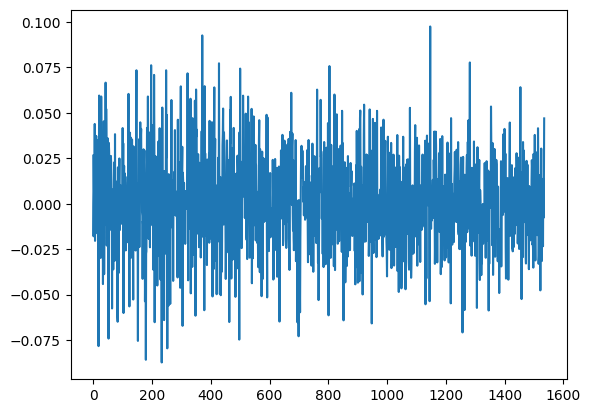

In [15]:
len(embeddings)
import numpy as np
k = list(embeddings.keys())[1]
print(k, 'Norm:', np.dot(embeddings[k],embeddings[k]))

import pandas as pd
pd.Series(embeddings[k], name=k).plot()

## Issues for RAG

How to homographs in our database affect our RAG systems.  Lets say we have a request to generate information about **sound**.

Our vector retrieval system looks for sentences in the database with a close proximity to 'sound'.  Lets look at the top matches:



### Basic RAG implementation



In [16]:
fields

['action',
 'animal',
 'arrangement',
 'distance',
 'emotion',
 'fish',
 'information',
 'injury',
 'metal',
 'music',
 'object',
 'sports',
 'undertaking']

0    0.784042
1    0.805869
2    0.842553
3    0.858344
4    0.873806
Name: cosine distances, dtype: float64

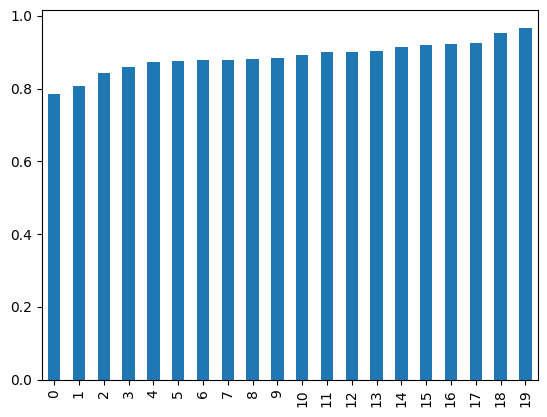

In [264]:
query = 'animal'
query_embedding = np.array(embeddings[query])
doc_embeddings = np.array([embeddings[d[0]] for d in docs])
results = cosine_distances(query_embedding[np.newaxis, :], doc_embeddings)

animal_doc_results = [docs[i] for i in list(np.argsort(results)[0])]

display(pd.Series(results[0, np.argsort(results)[0]], name="cosine distances").head())
pd.Series(results[0, np.argsort(results)[0]], name="cosine distances").plot(kind='bar')
for doc in animal_doc_results[:5]:
    render_entities(doc[0], ents=[doc[1]], colors=colors)

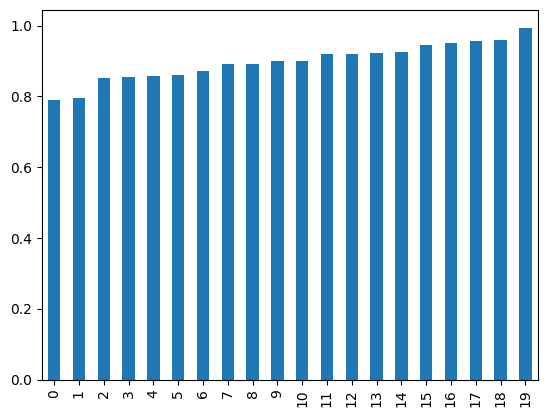

In [263]:
query = 'sports'
query_embedding = np.array(embeddings[query])
doc_embeddings = np.array([embeddings[d[0]] for d in docs])
results = cosine_distances(query_embedding[np.newaxis, :], doc_embeddings)

sports_doc_results = [docs[i] for i in list(np.argsort(results)[0])]

pd.Series(results[0, np.argsort(results)[0]], name="cosine distances").plot(kind='bar')
for doc in sports_doc_results[:5]:
    render_entities(doc[0], ents=[doc[1]], colors=colors)

# Solution 1: HyDE

rather than use the query embedding, use LLM to generate examples, build embeddings, generate average embedding and then use that to query

In [97]:
query = 'animal'

class Sentence(BaseModel):
    """brainstorm sentences about this topic
    """
    sentence: str

sentences = []
async for example in brainstorm(
    text=f"topic: \"{query}\"", 
    output_type=list[Sentence], 
    config=Config(),
    n=10,
    max_workers=1,
    temperature=0.2
):
    sentences.append(example)

sentences

[Sentence(sentence='The lion roared loudly in the jungle.'),
 Sentence(sentence='The elephant trumpeted as it walked through the savanna.'),
 Sentence(sentence='The birds chirped merrily in the trees.'),
 Sentence(sentence='The snake slithered silently through the grass.'),
 Sentence(sentence='The dolphins leaped gracefully out of the water.'),
 Sentence(sentence='The lion roared loudly in the jungle.'),
 Sentence(sentence='The elephant sprayed water from its trunk.'),
 Sentence(sentence='The birds chirped merrily in the trees.'),
 Sentence(sentence='The snake slithered silently through the grass.'),
 Sentence(sentence='The monkey swung from branch to branch in the forest.')]

0    0.556387
1    0.708210
2    0.715927
3    0.719031
4    0.728870
Name: cosine distances, dtype: float64

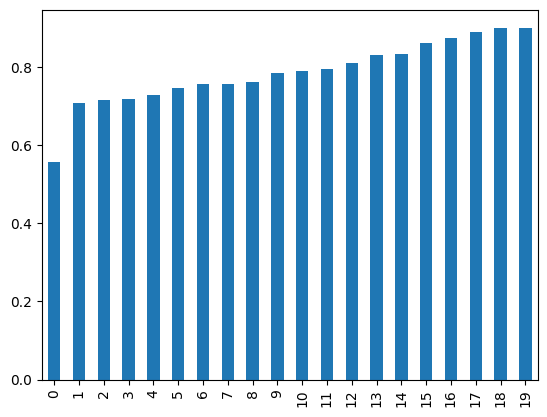

In [98]:
hyde_embeddings = np.array([np.array(get_embedding(s.sentence)) for s in sentences])
hyde_query_embedding = hyde_embeddings.mean(axis=0)

results = cosine_distances(hyde_query_embedding[np.newaxis, :], doc_embeddings)

doc_results = [docs[i] for i in list(np.argsort(results)[0])]

results_series = pd.Series(results[0, np.argsort(results)[0]], name="cosine distances")
display(results_series.head())
results_series.plot(kind='bar')
for doc in doc_results[:5]:
    render_entities(doc[0], ents=[doc[1]], colors=colors)

In [94]:
query = 'sports'

class Sentence(BaseModel):
    """brainstorm sentences about this topic
    """
    sentence: str

sentences = []
async for example in brainstorm(
    text=f"topic: \"{query}\"", 
    output_type=list[Sentence], 
    config=Config(),
    n=10,
    max_workers=1,
    temperature=0.2
):
    sentences.append(example)

sentences

[Sentence(sentence='The soccer game was intense.'),
 Sentence(sentence='She scored a touchdown in the final seconds.'),
 Sentence(sentence='The basketball team won the championship.'),
 Sentence(sentence='He hit a home run in the ninth inning.'),
 Sentence(sentence='The tennis match went into a tiebreaker.'),
 Sentence(sentence='The soccer game was intense.'),
 Sentence(sentence='She scored a touchdown in the final minute.'),
 Sentence(sentence='The Olympic relay race was thrilling to watch.'),
 Sentence(sentence='The basketball team won the championship.'),
 Sentence(sentence='He broke the world record in swimming.')]

0    0.587173
1    0.607294
2    0.630126
3    0.689125
4    0.693880
Name: cosine distances, dtype: float64

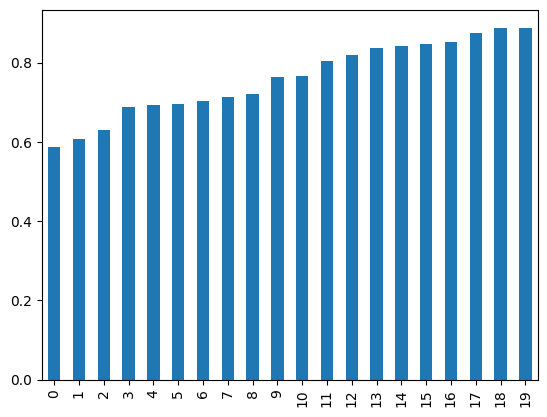

In [96]:
hyde_embeddings = np.array([np.array(get_embedding(s.sentence)) for s in sentences])
hyde_query_embedding = hyde_embeddings.mean(axis=0)

results = cosine_distances(hyde_query_embedding[np.newaxis, :], doc_embeddings)

doc_results = [docs[i] for i in list(np.argsort(results)[0])]

results_series = pd.Series(results[0, np.argsort(results)[0]], name="cosine distances")
display(results_series.head())
results_series.plot(kind='bar')
for doc in doc_results[:10]:
    render_entities(doc[0], ents=[doc[1]], colors=colors)

# Solution 2: Rerank

Call Cohere or other rerank service with the top embeddings

In [106]:
# !poetry add cohere

In [112]:
import cohere
from cohere.responses.classify import Example

# co = cohere.Client()

co_example_docs = ['Carson City is the capital city of the American state of Nevada.',
'The Commonwealth of the Northern Mariana Islands is a group of islands in the Pacific Ocean. Its capital is Saipan.',
'Washington, D.C. (also known as simply Washington or D.C., and officially as the District of Columbia) is the capital of the United States. It is a federal district.',
'Capital punishment (the death penalty) has existed in the United States since beforethe United States was a country. As of 2017, capital punishment is legal in 30 of the 50 states.']

response = co.rerank(
  model = 'rerank-english-v2.0',
  query = 'What is the capital of the United States?',
  documents = co_example_docs,
  top_n = 3,
)
print(response)

[RerankResult<document['text']: Washington, D.C. (also known as simply Washington or D.C., and officially as the District of Columbia) is the capital of the United States. It is a federal district., index: 2, relevance_score: 0.98005307>, RerankResult<document['text']: Capital punishment (the death penalty) has existed in the United States since beforethe United States was a country. As of 2017, capital punishment is legal in 30 of the 50 states., index: 3, relevance_score: 0.27904198>, RerankResult<document['text']: Carson City is the capital city of the American state of Nevada., index: 0, relevance_score: 0.10194652>]


0    0.784042
1    0.805869
2    0.842553
3    0.858344
4    0.873806
Name: cosine distances, dtype: float64

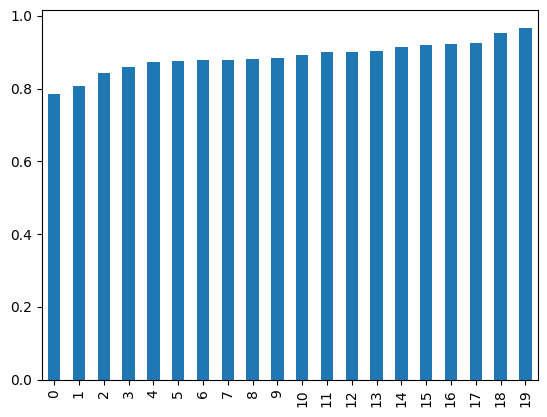

In [150]:
query = 'animal'
query_embedding = np.array(embeddings[query])
doc_embeddings = np.array([embeddings[d[0]] for d in docs])
results = cosine_distances(query_embedding[np.newaxis, :], doc_embeddings)

doc_results = [docs[i] for i in list(np.argsort(results)[0])]

display(pd.Series(results[0, np.argsort(results)[0]], name="cosine distances").head())
pd.Series(results[0, np.argsort(results)[0]], name="cosine distances").plot(kind='bar')
for doc in doc_results[:5]:
    render_entities(doc[0], ents=[doc[1]], colors=colors)

In [155]:
query = "animal"
response = co.rerank(
  model = 'rerank-english-v2.0',
  query = query,
  documents = [d[0] for d in doc_results[:10]],
  top_n = 5,
)
pd.DataFrame(
    [[r.document['text'], r.relevance_score, r.index] for r in response.results],
    columns=['text','score','index']
)

,text,score,index
0,Please close the door behind you.,0.501116,4
1,Please don't tear the paper.,0.403684,3
2,She will row the boat across the lake.,0.387285,7
3,The bat flew out of the cave at dusk.,0.289472,0
4,He wound the clock every evening.,0.213705,9


In [179]:
query = "sports"
response = co.rerank(
  model = 'rerank-english-v2.0',
  query = query,
  documents = [d[0] for d in docs],
  top_n = 5,
)
pd.DataFrame(
    [[r.document['text'], r.relevance_score, r.index] for r in response.results],
    columns=['text','score','index']
)

,text,score,index
0,Please don't tear the paper.,0.724091,17
1,Please close the door behind you.,0.672224,6
2,She will row the boat across the lake.,0.440259,14
3,The bat flew out of the cave at dusk.,0.391988,3
4,She had a tear in her eye when she said goodbye.,0.309858,16


## Solution 3:  Use an LLM Again

In [265]:
formatted_top_results = " * " + "\n * ".join([d[0] for d in animal_doc_results[:10]])
print(formatted_top_results)

 * The bat flew out of the cave at dusk.
 * He caught a large bass while fishing.
 * He used a baseball bat to hit the ball.
 * Please don't tear the paper.
 * Please close the door behind you.
 * She tied a bow in her hair.
 * He took a bow after his performance.
 * She will row the boat across the lake.
 * She will project her voice during the presentation.
 * He wound the clock every evening.


In [177]:
print(f"""Select sentences that pertain to the topic: \'{query}\'
only consider these sentences:
    
{formatted_top_results}
""")

Select sentences that pertain to the topic: 'sports'
only consider these sentences:
    
 * The bat flew out of the cave at dusk.
 * He caught a large bass while fishing.
 * He used a baseball bat to hit the ball.
 * Please don't tear the paper.
 * Please close the door behind you.
 * She tied a bow in her hair.
 * He took a bow after his performance.
 * She will row the boat across the lake.
 * She will project her voice during the presentation.
 * He wound the clock every evening.



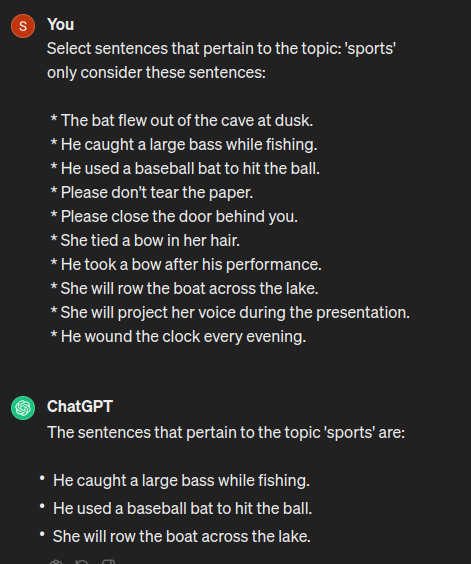

In [ ]:

import json

In [266]:
from openai import OpenAI
# client = OpenAI()
animal_results = client.chat.completions.create(
    messages= [
        {
            "role": "system",
            "content": "Return in a JSON list of strings a subset of the following sentences.  " \
            "Return all sentences pertaining to the topic 'animal' and ignore off-topic sentences. " \
            "The user will provide a list of sentences."
        },
        {
            "role": "user",
            "content": " * " + "\n * ".join([d[0] for d in animal_doc_results[:10]])
        }],
    model= 'gpt-3.5-turbo', # "Union[str, Literal['gpt-4-0125-preview', 'gpt-4-turbo-preview', 'gpt-4-1106-preview', 'gpt-4-vision-preview', 'gpt-4', 'gpt-4-0314', 'gpt-4-0613', 'gpt-4-32k', 'gpt-4-32k-0314', 'gpt-4-32k-0613', 'gpt-3.5-turbo', 'gpt-3.5-turbo-16k', 'gpt-3.5-turbo-0301', 'gpt-3.5-turbo-0613', 'gpt-3.5-turbo-1106', 'gpt-3.5-turbo-0125', 'gpt-3.5-turbo-16k-0613']]",
    temperature= 0.0,
    user= 'user',
)

animal_llm_filtered_results = json.loads(animal_results.choices[0].message.content)
animal_llm_filtered_results = [d for d in docs if d[0] in animal_llm_filtered_results]
for d in animal_llm_filtered_results:
    render_entities(d[0], ents=[d[1]])

In [279]:
from openai import OpenAI
# client = OpenAI()
sports_results = client.chat.completions.create(
    messages= [
        {
            "role": "system",
            "content": "Return in a JSON list of strings a subset of the following sentences.  " \
            "Return all sentences pertaining to the topic 'sport' and ignore off-topic sentences. " \
            "The user will provide a list of sentences."
        },
        {
            "role": "user",
            "content": " * " + "\n * ".join([d[0] for d in sports_doc_results[:10]])
        }],
    model= 'gpt-4-turbo-preview', # "Union[str, Literal['gpt-4-0125-preview', 'gpt-4-turbo-preview', 'gpt-4-1106-preview', 'gpt-4-vision-preview', 'gpt-4', 'gpt-4-0314', 'gpt-4-0613', 'gpt-4-32k', 'gpt-4-32k-0314', 'gpt-4-32k-0613', 'gpt-3.5-turbo', 'gpt-3.5-turbo-16k', 'gpt-3.5-turbo-0301', 'gpt-3.5-turbo-0613', 'gpt-3.5-turbo-1106', 'gpt-3.5-turbo-0125', 'gpt-3.5-turbo-16k-0613']]",
    temperature= 0.0,
)

r = sports_results.choices[0].message.content
r = r.replace('```json','').replace('```','').strip()
sports_llm_filtered_results = json.loads(r)
sports_llm_filtered_results = [d for d in docs if d[0] in sports_llm_filtered_results]
for d in sports_llm_filtered_results:
    render_entities(d[0], ents=[d[1]])

In [302]:
# !python -m spacy download en_core_web_sm
import spacy

def extract_svo(sentence):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(sentence)

    subject, verb, obj = None, None, None

    for token in doc:
        if "subj" in token.dep_:
            subject = token.text
        elif "obj" in token.dep_:
            obj = token.text
        elif "subjpass" in token.dep_:
            subject = token.text
        elif "ROOT" in token.dep_:
            verb = token.text

    return subject, verb, obj

# Example usage
sentence = "The cat chased the mouse"
result = extract_svo(sentence)
print(result)


('cat', 'chased', 'mouse')


In [303]:
import spacy

def parse_sentence(sentence):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(sentence)

    parsed_sentence = []

    for token in doc:
        parsed_token = {
            'text': token.text,
            'lemma': token.lemma_,
            'pos': token.pos_,
            'dep': token.dep_,
            'head': token.head.text
        }
        parsed_sentence.append(parsed_token)

    return parsed_sentence

# Example usage
sentence = "The cat chased the mouse"
result = parse_sentence(sentence)
for token in result:
    print(token)


{'text': 'The', 'lemma': 'the', 'pos': 'DET', 'dep': 'det', 'head': 'cat'}
{'text': 'cat', 'lemma': 'cat', 'pos': 'NOUN', 'dep': 'nsubj', 'head': 'chased'}
{'text': 'chased', 'lemma': 'chase', 'pos': 'VERB', 'dep': 'ROOT', 'head': 'chased'}
{'text': 'the', 'lemma': 'the', 'pos': 'DET', 'dep': 'det', 'head': 'mouse'}
{'text': 'mouse', 'lemma': 'mouse', 'pos': 'NOUN', 'dep': 'dobj', 'head': 'chased'}


In [304]:
import nltk

def split_sentences(paragraph):
    sentences = nltk.sent_tokenize(paragraph)
    return sentences

# Example usage
paragraph = "This is the first sentence. This is the second sentence. And this is the third sentence."
result = split_sentences(paragraph)

for idx, sentence in enumerate(result, start=1):
    print(f"Sentence {idx}: {sentence}")


Sentence 1: This is the first sentence.
Sentence 2: This is the second sentence.
Sentence 3: And this is the third sentence.


In [ ]:
!export NEURALCOREF_CACHE=/usr/local/data

In [315]:
import nltk
from nltk import pos_tag, RegexpParser
from nltk.tokenize import sent_tokenize, word_tokenize
from flair.models import SequenceTagger
from flair.data import Sentence

# Download NLTK resources (only needed once)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/skruz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/skruz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Alternative Approach, transforming text before embedding

Lets transform the sentence into Penman notation and express the text as an AMR Representation.

https://arxiv.org/pdf/2312.03480v1.pdf

In [329]:
len(docs)
for d in docs:
    print(d[0])

He caught a large bass while fishing.
The band played the bass guitar.
He used a baseball bat to hit the ball.
The bat flew out of the cave at dusk.
She tied a bow in her hair.
He took a bow after his performance.
Please close the door behind you.
The store is close to our house.
She was content with the results.
The website has a lot of content.
She will lead the team to victory.
The paint contains lead.
She will project her voice during the presentation.
The construction project is underway.
She will row the boat across the lake.
The students sit in a row in the classroom.
She had a tear in her eye when she said goodbye.
Please don't tear the paper.
The doctor treated the wound with care.
He wound the clock every evening.


In [334]:
amrs = [
    """(c / catch-01
   :ARG0 (h / he)
   :ARG1 (b / bass
         :mod (l / large))
   :time (w / while
         :op1 (f / fish-01
               :ARG0 h)))""",
"""(p / play-01
   :ARG0 (b / band)
   :ARG1 (g / guitar
         :mod (b2 / bass)))
""","""(u / use-01
   :ARG0 (h / he)
   :ARG1 (b / bat
         :mod (b2 / baseball))
   :purpose (h2 / hit-01
             :ARG0 h
             :ARG1 (b3 / ball)))
""","""(f / fly-01
   :ARG0 (b / bat)
   :direction (o / out
               :op1 (c / cave))
   :time (d / dusk))

""","""(t / tie-01
   :ARG0 (s / she)
   :ARG1 (b / bow)
   :location (h / hair
              :poss s))

""","""(t / take-01
   :ARG0 (h / he)
   :ARG1 (b / bow-02
         :time (a / after
                :op1 (p / perform-01
                      :ARG0 h))))

""","""(c / close-01
   :ARG1 (d / door)
   :location (b / behind
              :op1 (y / you)))

""","""(c / close-02
   :ARG1 (s / store)
   :ARG2 (h / house
          :poss (o / our)))

""","""(c / content-02
   :ARG0 (s / she)
   :ARG1 (r / result
         :mod (t / the)))

""",""" (h / have-03
   :ARG0 (w / website)
   :ARG1 (c / content
         :quant (a / a-lot-of)))
""","""(l / lead-01
   :ARG0 (s / she)
   :ARG1 (t / team)
   :ARG2 (v / victory))

""","""(c / contain-01
   :ARG0 (p / paint)
   :ARG1 (l / lead))

""","""(p / project-01
   :ARG0 (s / she)
   :ARG1 (v / voice)
   :time (d / during
          :op1 (p2 / presentation)))

""","""(u / underway
   :domain (p / project
            :mod (c / construction)))

""","""(r / row-01
   :ARG0 (s / she)
   :ARG1 (b / boat)
   :path (a / across
          :op1 (l / lake)))

""","""(s / sit-01
   :ARG0 (s2 / student :quant (t / the))
   :location (r / row
              :mod (a / a)
              :location (c / classroom)))

""","""(h / have-03
   :ARG0 (s / she)
   :ARG1 (t / tear-01
         :location (e / eye
                    :poss s))
   :time (w / when
          :op1 (s2 / say-01
                :ARG0 s
                :ARG1 (g / goodbye))))

""","""(t / tear-02
   :ARG0 (y / you)
   :ARG1 (p / paper)
   :modality (n / not))

""","""(t / treat-01
   :ARG0 (d / doctor)
   :ARG1 (w / wound)
   :manner (c / care))

""","""(w / wind-02
   :ARG0 (h / he)
   :ARG1 (c / clock)
   :frequency (e / every
               :op1 (e2 / evening)))

"""]
amrs = [a.strip() for a in amrs]
assert len(amrs) == len(docs)

In [396]:
amrs = [
  {"Subject": "He", "Verb": "caught", "Object": "a large bass"},
  {"Subject": "The band", "Verb": "played", "Object": "the bass guitar"},
  {"Subject": "He", "Verb": "used", "Object": "a baseball bat"},
  {"Subject": "The bat", "Verb": "flew", "Object": "out of the cave"},
  {"Subject": "She", "Verb": "tied", "Object": "a bow in her hair"},
  {"Subject": "He", "Verb": "took", "Object": "a bow"},
  {"Subject": "You", "Verb": "close", "Object": "the door behind you"},
  {"Subject": "The store", "Verb": "is", "Object": "close to our house"},
  {"Subject": "She", "Verb": "was", "Object": "content with the results"},
  {"Subject": "The website", "Verb": "has", "Object": "a lot of content"},
  {"Subject": "She", "Verb": "will lead", "Object": "the team to victory"},
  {"Subject": "The paint", "Verb": "contains", "Object": "lead"},
  {"Subject": "She", "Verb": "will project", "Object": "her voice during the presentation"},
  {"Subject": "The construction project", "Verb": "is", "Object": "underway"},
  {"Subject": "She", "Verb": "will row", "Object": "the boat across the lake"},
  {"Subject": "The students", "Verb": "sit", "Object": "in a row in the classroom"},
  {"Subject": "She", "Verb": "had", "Object": "a tear in her eye"},
  {"Subject": "You", "Verb": "don't tear", "Object": "the paper"},
  {"Subject": "The doctor", "Verb": "treated", "Object": "the wound with care"},
  {"Subject": "He", "Verb": "wound", "Object": "the clock every evening"}
]
amrs = [f"{a['Subject']} {a['Verb']} {a['Object']}" for a in amrs]
amrs

['He caught a large bass',
 'The band played the bass guitar',
 'He used a baseball bat',
 'The bat flew out of the cave',
 'She tied a bow in her hair',
 'He took a bow',
 'You close the door behind you',
 'The store is close to our house',
 'She was content with the results',
 'The website has a lot of content',
 'She will lead the team to victory',
 'The paint contains lead',
 'She will project her voice during the presentation',
 'The construction project is underway',
 'She will row the boat across the lake',
 'The students sit in a row in the classroom',
 'She had a tear in her eye',
 "You don't tear the paper",
 'The doctor treated the wound with care',
 'He wound the clock every evening']

In [397]:
amrs_embeddings = {}

for amr, doc in zip(amrs, docs):
    amrs_embeddings[doc[0]] = get_embedding(amr)
    

In [398]:
len(embeddings)

43

In [399]:
all_embeddings = np.array([embeddings[d[0]] for d in docs] + [amrs_embeddings[d[0]] for d in docs])
all_embeddings.shape

(40, 1536)

In [400]:
fields

['action',
 'animal',
 'arrangement',
 'distance',
 'emotion',
 'fish',
 'information',
 'injury',
 'metal',
 'music',
 'object',
 'sports',
 'undertaking']

In [401]:
fields.index('music')

9

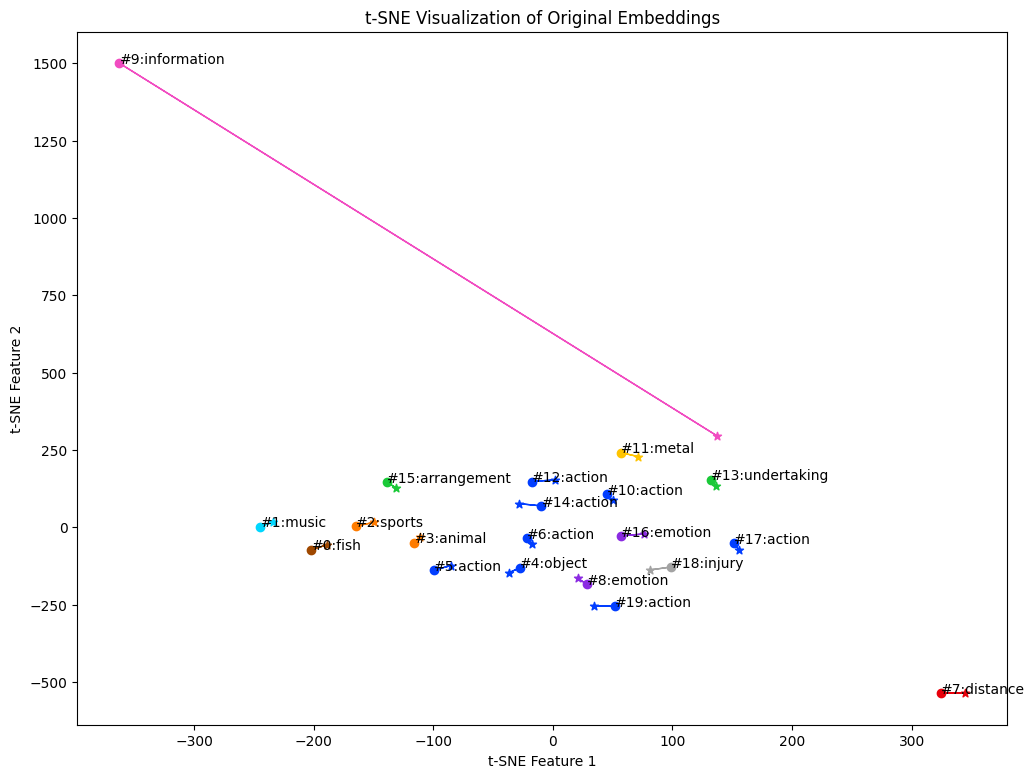

In [402]:
## T-SNE
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
# Original embeddings (vectors)
# X = np.array(embeddings[0][1:])
# X = np.concatenate([np.array(v[1:]) for v in embeddings], axis=0)

# Create a t-SNE model
tsne = TSNE(n_components=2, random_state=42, perplexity=4)  # Using 2 components for 2D visualization

# Fit and transform the data with t-SNE
X_tsne = tsne.fit_transform(all_embeddings)

palette = sns.color_palette("bright", len(fields))

# Plot the t-SNE transformed data
plt.figure(figsize=(12, 9))
k = -1
for i in range(len(X_tsne)):
    k = i % len(docs)
    field = docs[k][1].label
    if i >= len(docs):
        plt.arrow(X_tsne[i-len(docs), 0], X_tsne[i-len(docs), 1],X_tsne[i, 0]-X_tsne[i-len(docs), 0], X_tsne[i, 1]-X_tsne[i-len(docs), 1], head_width=0.1, head_length=0.1, fc=palette[fields.index(field)], ec=palette[fields.index(field)])
        plt.scatter(X_tsne[i, 0], X_tsne[i, 1], color=palette[fields.index(field)], marker='*')
    else:
        plt.text(X_tsne[i, 0], X_tsne[i, 1], f"#{i}:{field}", fontdict={'size': 10})  
        plt.scatter(X_tsne[i, 0], X_tsne[i, 1], color=palette[fields.index(field)])


plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('t-SNE Visualization of Original Embeddings')
plt.show()

In [403]:
[(i, d[0]) for i,d in enumerate(docs) if d[1].label == 'emotion']

[(8, 'She was content with the results.'),
 (16, 'She had a tear in her eye when she said goodbye.')]

In [412]:
print(amrs[9], docs[9][0])

The website has a lot of content The website has a lot of content.


In [405]:
print(amrs[16])

She had a tear in her eye


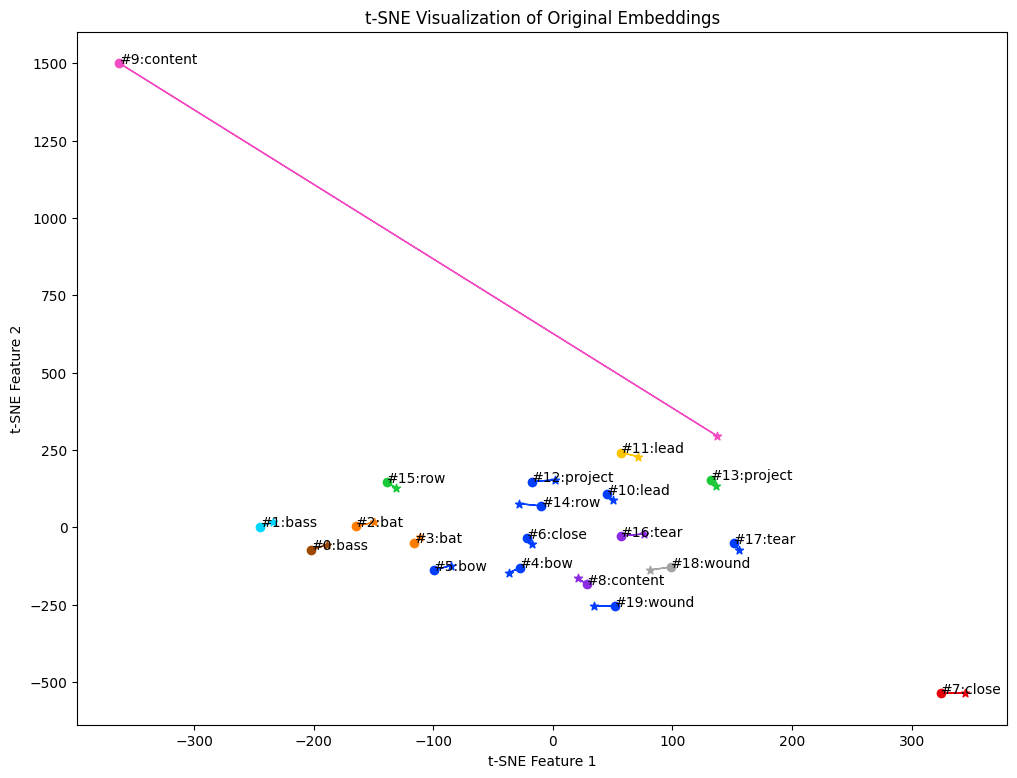

In [406]:
## T-SNE
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
# Original embeddings (vectors)
# X = np.array(embeddings[0][1:])
# X = np.concatenate([np.array(v[1:]) for v in embeddings], axis=0)

# Create a t-SNE model
tsne = TSNE(n_components=2, random_state=42, perplexity=4)  # Using 2 components for 2D visualization

# Fit and transform the data with t-SNE
X_tsne = tsne.fit_transform(all_embeddings)

palette = sns.color_palette("bright", len(fields))

# Plot the t-SNE transformed data
plt.figure(figsize=(12, 9))
k = -1
for i in range(len(X_tsne)):
    k = i % len(docs)
    field = docs[k][1].label
    if i >= len(docs):
        plt.arrow(X_tsne[i-len(docs), 0], X_tsne[i-len(docs), 1],X_tsne[i, 0]-X_tsne[i-len(docs), 0], X_tsne[i, 1]-X_tsne[i-len(docs), 1], head_width=0.1, head_length=0.1, fc=palette[fields.index(field)], ec=palette[fields.index(field)])
        plt.scatter(X_tsne[i, 0], X_tsne[i, 1], color=palette[fields.index(field)], marker='*')
    else:
        label = docs[k][1].text
        plt.text(X_tsne[i, 0], X_tsne[i, 1], f"#{i}:{label}", fontdict={'size': 10})  
        plt.scatter(X_tsne[i, 0], X_tsne[i, 1], color=palette[fields.index(field)])


plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('t-SNE Visualization of Original Embeddings')
plt.show()

0    0.784042
1    0.805869
2    0.842553
3    0.858344
4    0.873806
Name: cosine distances, dtype: float64

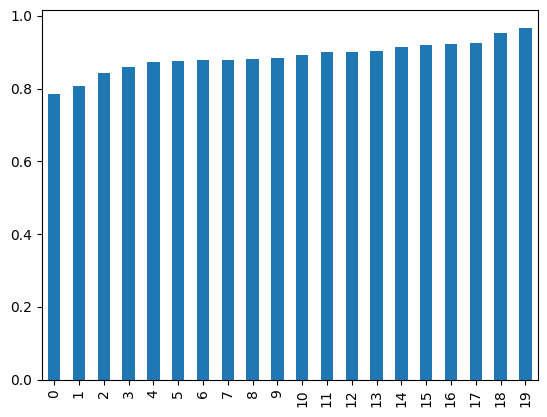

In [413]:
# Reminder of old approach
query = 'animal'
query_embedding = np.array(embeddings[query])
doc_embeddings = np.array([embeddings[d[0]] for d in docs])
results = cosine_distances(query_embedding[np.newaxis, :], doc_embeddings)

animal_doc_results = [docs[i] for i in list(np.argsort(results)[0])]

display(pd.Series(results[0, np.argsort(results)[0]], name="cosine distances").head())
pd.Series(results[0, np.argsort(results)[0]], name="cosine distances").plot(kind='bar')
for doc in animal_doc_results[:5]:
    render_entities(doc[0], ents=[doc[1]], colors=colors)

0    0.750600
1    0.799577
2    0.800752
3    0.844096
4    0.845353
Name: cosine distances, dtype: float64

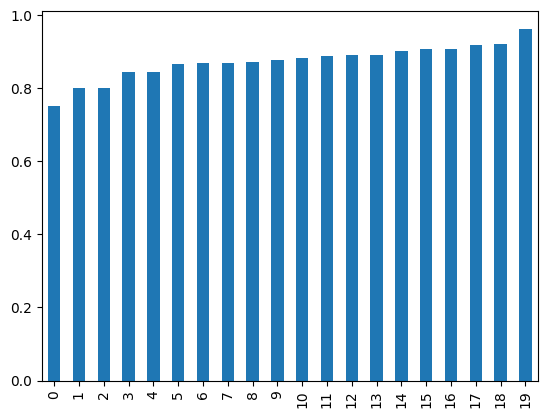

In [414]:
# Reminder of old approach
query = 'animal'
query_embedding = np.array(embeddings[query])
amrs_doc_embeddings = np.array([amrs_embeddings[d[0]] for d in docs])
results = cosine_distances(query_embedding[np.newaxis, :], amrs_doc_embeddings)

animal_doc_results_amrs = [docs[i] for i in list(np.argsort(results)[0])]

display(pd.Series(results[0, np.argsort(results)[0]], name="cosine distances").head())
pd.Series(results[0, np.argsort(results)[0]], name="cosine distances").plot(kind='bar')
for doc in animal_doc_results_amrs[:5]:
    render_entities(doc[0], ents=[doc[1]], colors=colors)

0    0.765031
1    0.782302
2    0.839683
3    0.844377
4    0.851662
Name: cosine distances, dtype: float64

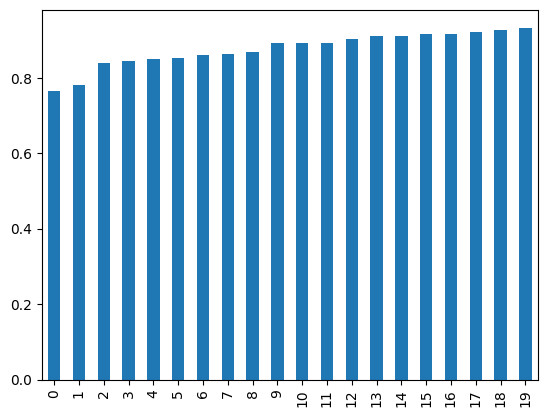

In [415]:
# Reminder of old approach
query = 'sports'
query_embedding = np.array(embeddings[query])
amrs_doc_embeddings = np.array([amrs_embeddings[d[0]] for d in docs])
results = cosine_distances(query_embedding[np.newaxis, :], amrs_doc_embeddings)

sports_doc_results_amrs = [docs[i] for i in list(np.argsort(results)[0])]

display(pd.Series(results[0, np.argsort(results)[0]], name="cosine distances").head())
pd.Series(results[0, np.argsort(results)[0]], name="cosine distances").plot(kind='bar')
for doc in sports_doc_results_amrs[:5]:
    render_entities(doc[0], ents=[doc[1]], colors=colors)

In [418]:
x = pd.Series(results[0, np.argsort(results)[0]], name="cosine distances")
x.median() - 2*x.std()

0.800950209754562

In [316]:
def coreference_resolution(paragraph):
    # Load Flair coreference resolution model
    coref_tagger = SequenceTagger.load('coreference')

    # Use Flair to perform coreference resolution
    sentence = Sentence(paragraph)
    coref_tagger.predict(sentence)

    resolved_entities = []

    for cluster in sentence.get_spans('coref'):
        main_reference = cluster.text
        references = [mention.text for mention in cluster.get_referenced()]

        resolved_entities.append({
            'main_reference': main_reference,
            'references': references
        })

    return resolved_entities

def split_sentences(paragraph):
    sentences = sent_tokenize(paragraph)
    return sentences

def extract_svo(sentence):
    # Replace this with your preferred method for extracting SVOs
    pass

def process_paragraph(paragraph):
    # Coreference resolution
    resolved_entities = coreference_resolution(paragraph)

    # Split sentences using Flair
    sentence = Sentence(paragraph)
    sentence_tokenizer = Sentence.split_tokens(sentence)
    sentences = [str(sent) for sent in sentence_tokenizer]

    # Extract SVOs
    svo_result = []

    for sentence in sentences:
        svo_result.extend(extract_svo(sentence))

    # Rename elements based on coreference resolution
    for entity in resolved_entities:
        main_reference = entity['main_reference']
        references = entity['references']

        for idx, svo_tuple in enumerate(svo_result):
            subject, verb, obj = svo_tuple
            if subject in references:
                svo_result[idx] = (main_reference, verb, obj)
            if obj in references:
                svo_result[idx] = (subject, verb, main_reference)

    return svo_result

# Example usage
paragraph = "John and Mary are good friends. They went to the park together. He enjoyed the sunny weather."
result = process_paragraph(paragraph)

for svo_tuple in result:
    print(svo_tuple)

RepositoryNotFoundError: 401 Client Error. (Request ID: Root=1-65ce4b66-53c06fe0765b57a8519c948c;25cd6cf6-5fc1-4b9a-968d-cdedd080a840)

Repository Not Found for url: https://huggingface.co/coreference/resolve/main/pytorch_model.bin.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.
Invalid username or password.

In [313]:
# !poetry add flair

Using version ^0.13.1 for flair

Updating dependencies
Resolving dependencies... (6.8s)s://files.pythonhosted.org/packages/73/7d/70f4069f4bbf0fca023e82a1fbbade6f5216365d4fe259fee1950723eca5/Janome-0.5.0-py2.py3-none-any.whl  99% (3.0s)Resolving dependencies... (3.9s)Resolving dependencies... (5.5s)

Package operations: 42 installs, 1 update, 0 removals

  • Installing nvidia-nvjitlink-cu12 (12.3.101): Pending...
  • Installing nvidia-nvjitlink-cu12 (12.3.101): Installing...
  • Installing nvidia-nvjitlink-cu12 (12.3.101)
  • Installing mpmath (1.3.0): Pending...
  • Installing nvidia-cublas-cu12 (12.1.3.1): Pending...
  • Installing nvidia-cusparse-cu12 (12.1.0.106): Pending...
  • Downgrading urllib3 (2.2.0 -> 1.26.18): Pending...
  • Installing nvidia-cublas-cu12 (12.1.3.1): Pending...
  • Installing nvidia-cusparse-cu12 (12.1.0.106): Pending...
  • Downgrading urllib3 (2.2.0 -> 1.26.18): Pending...
  • Installing mpmath (1.3.0): Installing...
  • Installing nvidia-cublas-cu12 (12.1.

  • Installing nvidia-nvtx-cu12 (12.1.105): Pending...
  • Installing sympy (1.12): Pending...
  • Installing triton (2.2.0): Pending...
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 0%
  • Installing nvidia-nvtx-cu12 (12.1.105): Pending...
  • Installing sympy (1.12): Pending...
  • Installing triton (2.2.0): Pending...
  • Installing nvidia-cuda-nvrtc-cu12 (12.1.105): Pending...
  • Installing nvidia-cuda-runtime-cu12 (12.1.105): Installing...
  • Installing nvidia-cudnn-cu12 (8.9.2.26): Pending...
  • Installing nvidia-cufft-cu12 (11.0.2.54): Pending...
  • Installing nvidia-curand-cu12 (10.3.2.106): Pending...
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Pending...
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 0%
  • Installing nvidia-nvtx-cu12 (12.1.105): Pending...
  • Installing sympy (1.12): Pending...
  • Installing triton (2.2.0): Pending...
  • Installing nvidia-cuda-cupti-cu12 (12.1.105): Installing...
  • Installing nvidia-cuda-nvrtc-cu12 (12.1.1

  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12): Pending...
  • Installing triton (2.2.0): Pending...
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 20%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12): Pending...
  • Installing triton (2.2.0): Pending...
  • Installing triton (2.2.0): Pending...
  • Installing sympy (1.12): Installing...
  • Installing triton (2.2.0): Pending...
  • Installing nvidia-cufft-cu12 (11.0.2.54): Pending...
  • Installing nvidia-curand-cu12 (10.3.2.106): Pending...
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Pending...
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 20%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12): Installing...
  • Installing triton (2.2.0): Pending...
  • Installing nvidia-cudnn-cu12 (8.9.2.26): Downloading... 0%
  • Installing nvidia-cufft-cu12 (11.0.2.54): Pending...
  • Installing nvidia-curand-cu12 (10.3.2.106): Pending...
  • Installing nv

  • Installing triton (2.2.0): Downloading... 0%
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 0%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 30%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12): Installing...
  • Installing triton (2.2.0): Downloading... 0%
  • Installing nvidia-curand-cu12 (10.3.2.106): Downloading... 10%
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 0%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 30%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12): Installing...
  • Installing triton (2.2.0): Downloading... 0%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12): Installing...
  • Installing triton (2.2.0): Downloading... 0%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 40%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12): Installing...
  • Installing triton (2.2.0): Downloading... 0%
  • Installing triton (2.

  • Installing nvidia-cufft-cu12 (11.0.2.54): Downloading... 10%
  • Installing nvidia-curand-cu12 (10.3.2.106): Downloading... 20%
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 0%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 40%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 0%
  • Installing nvidia-cudnn-cu12 (8.9.2.26): Downloading... 1%
  • Installing nvidia-cufft-cu12 (11.0.2.54): Downloading... 10%
  • Installing nvidia-curand-cu12 (10.3.2.106): Downloading... 20%
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 0%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 40%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 0%
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 0%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 40%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  •

  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 4%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 50%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 10%
  • Installing nvidia-curand-cu12 (10.3.2.106): Downloading... 50%
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 4%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 50%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 10%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 50%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 10%
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 10%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 50%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 10%


  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 10%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 60%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 20%
  • Installing nvidia-curand-cu12 (10.3.2.106): Downloading... 70%
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 10%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 60%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 20%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 20%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 70%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 20%
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 10%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 70

  • Installing nvidia-cufft-cu12 (11.0.2.54): Downloading... 40%
  • Installing nvidia-curand-cu12 (10.3.2.106): Downloading... 90%
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 19%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 80%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 30%
  • Installing nvidia-cudnn-cu12 (8.9.2.26): Downloading... 4%
  • Installing nvidia-cufft-cu12 (11.0.2.54): Downloading... 40%
  • Installing nvidia-curand-cu12 (10.3.2.106): Downloading... 90%
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 19%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 80%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 30%
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 19%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 80%
  • Installing nvidia-nvtx-cu12 (12.1.105

  • Installing nvidia-cufft-cu12 (11.0.2.54): Downloading... 60%
  • Installing nvidia-curand-cu12 (10.3.2.106): Installing...
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 30%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 90%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 40%
  • Installing nvidia-cudnn-cu12 (8.9.2.26): Downloading... 7%
  • Installing nvidia-cufft-cu12 (11.0.2.54): Downloading... 60%
  • Installing nvidia-curand-cu12 (10.3.2.106): Installing...
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 30%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 90%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 40%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 40%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 100

  • Installing nvidia-cufft-cu12 (11.0.2.54): Downloading... 80%
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 40%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 100%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 60%
  • Installing nvidia-cudnn-cu12 (8.9.2.26): Downloading... 9%
  • Installing nvidia-cufft-cu12 (11.0.2.54): Downloading... 80%
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 40%
  • Installing nvidia-nccl-cu12 (2.19.3): Downloading... 100%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 60%
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 60%
  • Installing nvidia-nccl-cu12 (2.19.3): Installing...
  • Installing nvidia-nvtx-cu12 

  • Installing triton (2.2.0): Downloading... 80%
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 60%
  • Installing nvidia-nccl-cu12 (2.19.3): Installing...
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 80%
  • Installing nvidia-cufft-cu12 (11.0.2.54): Downloading... 100%
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 60%
  • Installing nvidia-nccl-cu12 (2.19.3): Installing...
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 80%
  • Installing nvidia-nccl-cu12 (2.19.3): Installing...
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 80%
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 70%
  • Installing nvidia-nccl-cu12 (2.19.3): Installing

  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 100%
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 100%
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 100%
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 90%
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Downloading... 100%
  • Installing nvidia-cufft-cu12 (11.0.2.54): Installing...
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Downloading... 90%
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): D

  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Installing...
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Installing...
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Installing...
Installing /home/skruz/.cache/pypoetry/virtualenvs/promptedgraphs-y6c3HIib-py3.10/lib/python3.10/site-packages/nvidia/__init__.py over existing file
  • Installing nvidia-cufft-cu12 (11.0.2.54)
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107): Installing...
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0): Installing...
  • Installing nvidia-cudnn-cu12 (8.9.2.26): Downloading... 23%
  • Installing nvidia-cufft-cu12 (11.0.2.54)
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • 

  • Installing nvidia-cufft-cu12 (11.0.2.54)
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107)
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0)
  • Installing nvidia-cudnn-cu12 (8.9.2.26): Downloading... 37%
  • Installing nvidia-cufft-cu12 (11.0.2.54)
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107)
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0)
  • Installing nvidia-cufft-cu12 (11.0.2.54)
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107)
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0)
  • Installing nvidia-cudnn-cu12 (8.9.2.26): Downloading... 40%
  • Installing nvidia-c

  • Installing nvidia-cufft-cu12 (11.0.2.54)
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107)
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0)
  • Installing nvidia-cudnn-cu12 (8.9.2.26): Downloading... 54%
  • Installing nvidia-cufft-cu12 (11.0.2.54)
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107)
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0)
  • Installing nvidia-cufft-cu12 (11.0.2.54)
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107)
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0)
  • Installing nvidia-cudnn-cu12 (8.9.2.26): Downloading... 60%
  • Installing nvidia-c

  • Installing nvidia-cufft-cu12 (11.0.2.54)
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107)
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0)
  • Installing nvidia-cudnn-cu12 (8.9.2.26): Downloading... 80%
  • Installing nvidia-cufft-cu12 (11.0.2.54)
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107)
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0)
  • Installing nvidia-cufft-cu12 (11.0.2.54)
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107)
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0)
  • Installing nvidia-cudnn-cu12 (8.9.2.26): Downloading... 88%
  • Installing nvidia-c

  • Installing nvidia-cufft-cu12 (11.0.2.54)
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107)
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0)
  • Installing nvidia-cudnn-cu12 (8.9.2.26): Installing...
  • Installing nvidia-cufft-cu12 (11.0.2.54)
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107)
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
  • Installing sympy (1.12)
  • Installing triton (2.2.0)
Installing /home/skruz/.cache/pypoetry/virtualenvs/promptedgraphs-y6c3HIib-py3.10/lib/python3.10/site-packages/nvidia/__init__.py over existing file
  • Installing nvidia-cufft-cu12 (11.0.2.54)
  • Installing nvidia-curand-cu12 (10.3.2.106)
  • Installing nvidia-cusolver-cu12 (11.4.5.107)
  • Installing nvidia-nccl-cu12 (2.19.3)
  • Installing nvidia-nvtx-cu12 (12.1.105)
 

  • Installing pysocks (1.7.1): Pending...
  • Installing botocore (1.34.42): Downloading... 0%
  • Installing pysocks (1.7.1): Pending...
  • Installing pysocks (1.7.1): Downloading... 0%
  • Installing pysocks (1.7.1): Downloading... 100%
  • Installing pysocks (1.7.1): Installing...
  • Installing pysocks (1.7.1)
  • Installing botocore (1.34.42): Downloading... 0%
  • Installing pysocks (1.7.1)
  • Installing accelerate (0.27.2)
  • Installing botocore (1.34.42): Downloading... 0%
  • Installing pysocks (1.7.1)
  • Installing pysocks (1.7.1)
  • Installing botocore (1.34.42): Downloading... 20%
  • Installing pysocks (1.7.1)
  • Installing pysocks (1.7.1)
  • Installing botocore (1.34.42): Downloading... 50%
  • Installing pysocks (1.7.1)
  • Installing pysocks (1.7.1)
  • Installing botocore (1.34.42): Downloading... 70%
  • Installing pysocks (1.7.1)
  • Installing pysocks (1.7.1)
  • Installing botocore (1.34.42): Downloading... 90%
  • Installing pysocks (1.7.1)
  • Installing 

  • Installing wrapt (1.16.0)
  • Installing sentencepiece (0.1.99)
  • Installing wrapt (1.16.0)
  • Installing s3transfer (0.10.0)
  • Installing sentencepiece (0.1.99)
  • Installing wrapt (1.16.0)
  • Installing gensim (4.3.2): Downloading... 40%
  • Installing s3transfer (0.10.0)
  • Installing sentencepiece (0.1.99)
  • Installing wrapt (1.16.0)
  • Installing s3transfer (0.10.0)
  • Installing sentencepiece (0.1.99)
  • Installing wrapt (1.16.0)
  • Installing gensim (4.3.2): Downloading... 80%
  • Installing s3transfer (0.10.0)
  • Installing sentencepiece (0.1.99)
  • Installing wrapt (1.16.0)
  • Installing s3transfer (0.10.0)
  • Installing sentencepiece (0.1.99)
  • Installing wrapt (1.16.0)
  • Installing gensim (4.3.2): Downloading... 100%
  • Installing s3transfer (0.10.0)
  • Installing sentencepiece (0.1.99)
  • Installing wrapt (1.16.0)
  • Installing s3transfer (0.10.0)
  • Installing sentencepiece (0.1.99)
  • Installing wrapt (1.16.0)
  • Installing gensim (4.3.2):

  • Installing conllu (4.5.3): Pending...
  • Installing deprecated (1.2.14)
  • Installing ftfy (6.1.3): Installing...
  • Installing gdown (5.1.0): Pending...
  • Installing janome (0.5.0): Downloading... 0%
  • Installing langdetect (1.0.9): Downloading... 0%
  • Installing lxml (5.1.0): Downloading... 0%
  • Installing mpld3 (0.5.10): Pending...
  • Installing pptree (3.1): Pending...
  • Installing pytorch-revgrad (0.2.0): Pending...
  • Installing segtok (1.5.11): Pending...
  • Installing bpemb (0.3.4)
  • Installing conllu (4.5.3): Pending...
  • Installing deprecated (1.2.14)
  • Installing ftfy (6.1.3): Installing...
  • Installing gdown (5.1.0): Pending...
  • Installing janome (0.5.0): Downloading... 0%
  • Installing langdetect (1.0.9): Downloading... 0%
  • Installing lxml (5.1.0): Downloading... 0%
  • Installing mpld3 (0.5.10): Pending...
  • Installing pptree (3.1): Pending...
  • Installing pytorch-revgrad (0.2.0): Pending...
  • Installing segtok (1.5.11): Pending...

  • Installing lxml (5.1.0): Downloading... 10%
  • Installing mpld3 (0.5.10): Pending...
  • Installing pptree (3.1): Pending...
  • Installing pytorch-revgrad (0.2.0): Pending...
  • Installing segtok (1.5.11): Installing...
  • Installing semver (3.0.2): Pending...
  • Installing sqlitedict (2.1.0): Pending...
  • Installing langdetect (1.0.9): Preparing...
  • Installing lxml (5.1.0): Downloading... 10%
  • Installing mpld3 (0.5.10): Pending...
  • Installing pptree (3.1): Pending...
  • Installing pytorch-revgrad (0.2.0): Pending...
  • Installing segtok (1.5.11): Installing...
  • Installing semver (3.0.2): Pending...
  • Installing sqlitedict (2.1.0): Pending...
  • Installing sqlitedict (2.1.0): Pending...
  • Installing semver (3.0.2): Downloading... 0%
  • Installing sqlitedict (2.1.0): Pending...
  • Installing sqlitedict (2.1.0): Pending...
  • Installing semver (3.0.2): Downloading... 100%
  • Installing sqlitedict (2.1.0): Pending...
  • Installing sqlitedict (2.1.0): Pen

  • Installing wikipedia-api (0.6.0): Pending...
  • Installing transformer-smaller-training-vocab (0.3.3): Downloading... 100%
  • Installing wikipedia-api (0.6.0): Pending...
  • Installing wikipedia-api (0.6.0): Pending...
  • Installing transformer-smaller-training-vocab (0.3.3): Installing...
  • Installing wikipedia-api (0.6.0): Pending...
  • Installing wikipedia-api (0.6.0): Downloading... 0%
  • Installing wikipedia-api (0.6.0): Downloading... 100%
  • Installing wikipedia-api (0.6.0): Installing...
  • Installing wikipedia-api (0.6.0): Installing...
  • Installing transformer-smaller-training-vocab (0.3.3)
  • Installing wikipedia-api (0.6.0): Installing...
  • Installing wikipedia-api (0.6.0)
  • Installing mpld3 (0.5.10): Pending...
  • Installing pptree (3.1): Pending...
  • Installing pytorch-revgrad (0.2.0): Pending...
  • Installing segtok (1.5.11)
  • Installing semver (3.0.2)
  • Installing sqlitedict (2.1.0): Preparing...
  • Installing transformer-smaller-training-v

  • Installing mpld3 (0.5.10): Pending...
  • Installing pptree (3.1): Pending...
  • Installing pytorch-revgrad (0.2.0): Pending...
  • Installing segtok (1.5.11)
  • Installing semver (3.0.2)
  • Installing sqlitedict (2.1.0): Preparing...
  • Installing transformer-smaller-training-vocab (0.3.3)
  • Installing wikipedia-api (0.6.0)
  • Installing lxml (5.1.0): Installing...
  • Installing mpld3 (0.5.10): Pending...
  • Installing pptree (3.1): Pending...
  • Installing pytorch-revgrad (0.2.0): Pending...
  • Installing segtok (1.5.11)
  • Installing semver (3.0.2)
  • Installing sqlitedict (2.1.0): Preparing...
  • Installing transformer-smaller-training-vocab (0.3.3)
  • Installing wikipedia-api (0.6.0)
  • Installing langdetect (1.0.9): Preparing...
  • Installing lxml (5.1.0): Installing...
  • Installing mpld3 (0.5.10): Pending...
  • Installing pptree (3.1): Pending...
  • Installing pytorch-revgrad (0.2.0): Pending...
  • Installing segtok (1.5.11)
  • Installing semver (3.0.2

  • Installing janome (0.5.0): Downloading... 80%
  • Installing langdetect (1.0.9): Preparing...
  • Installing lxml (5.1.0): Installing...
  • Installing mpld3 (0.5.10): Downloading... 0%
  • Installing pptree (3.1): Preparing...
  • Installing pytorch-revgrad (0.2.0)
  • Installing segtok (1.5.11)
  • Installing semver (3.0.2)
  • Installing sqlitedict (2.1.0): Preparing...
  • Installing transformer-smaller-training-vocab (0.3.3)
  • Installing wikipedia-api (0.6.0)
  • Installing gdown (5.1.0)
  • Installing janome (0.5.0): Downloading... 80%
  • Installing langdetect (1.0.9): Preparing...
  • Installing lxml (5.1.0): Installing...
  • Installing mpld3 (0.5.10): Downloading... 0%
  • Installing pptree (3.1): Preparing...
  • Installing pytorch-revgrad (0.2.0)
  • Installing segtok (1.5.11)
  • Installing semver (3.0.2)
  • Installing sqlitedict (2.1.0): Preparing...
  • Installing transformer-smaller-training-vocab (0.3.3)
  • Installing wikipedia-api (0.6.0)
  • Installing deprec

  • Installing deprecated (1.2.14)
  • Installing ftfy (6.1.3)
  • Installing gdown (5.1.0)
  • Installing janome (0.5.0): Downloading... 100%
  • Installing langdetect (1.0.9): Preparing...
  • Installing lxml (5.1.0): Installing...
  • Installing mpld3 (0.5.10): Downloading... 10%
  • Installing pptree (3.1): Preparing...
  • Installing pytorch-revgrad (0.2.0)
  • Installing segtok (1.5.11)
  • Installing semver (3.0.2)
  • Installing sqlitedict (2.1.0): Preparing...
  • Installing transformer-smaller-training-vocab (0.3.3)
  • Installing wikipedia-api (0.6.0)
  • Installing conllu (4.5.3): Downloading... 100%
  • Installing deprecated (1.2.14)
  • Installing ftfy (6.1.3)
  • Installing gdown (5.1.0)
  • Installing janome (0.5.0): Downloading... 100%
  • Installing langdetect (1.0.9): Preparing...
  • Installing lxml (5.1.0): Installing...
  • Installing mpld3 (0.5.10): Downloading... 10%
  • Installing pptree (3.1): Preparing...
  • Installing pytorch-revgrad (0.2.0)
  • Installing 

  • Installing langdetect (1.0.9): Preparing...
  • Installing lxml (5.1.0): Installing...
  • Installing mpld3 (0.5.10): Downloading... 10%
  • Installing pptree (3.1): Preparing...
  • Installing pytorch-revgrad (0.2.0)
  • Installing segtok (1.5.11)
  • Installing semver (3.0.2)
  • Installing sqlitedict (2.1.0): Preparing...
  • Installing transformer-smaller-training-vocab (0.3.3)
  • Installing wikipedia-api (0.6.0)
  • Installing janome (0.5.0): Installing...
  • Installing langdetect (1.0.9): Preparing...
  • Installing lxml (5.1.0): Installing...
  • Installing mpld3 (0.5.10): Downloading... 10%
  • Installing pptree (3.1): Preparing...
  • Installing pytorch-revgrad (0.2.0)
  • Installing segtok (1.5.11)
  • Installing semver (3.0.2)
  • Installing sqlitedict (2.1.0): Preparing...
  • Installing transformer-smaller-training-vocab (0.3.3)
  • Installing wikipedia-api (0.6.0)
  • Installing bpemb (0.3.4)
  • Installing conllu (4.5.3)
  • Installing deprecated (1.2.14)
  • Insta

  • Installing bpemb (0.3.4)
  • Installing conllu (4.5.3)
  • Installing deprecated (1.2.14)
  • Installing ftfy (6.1.3)
  • Installing gdown (5.1.0)
  • Installing janome (0.5.0): Installing...
  • Installing langdetect (1.0.9): Preparing...
  • Installing lxml (5.1.0): Installing...
  • Installing mpld3 (0.5.10)
  • Installing pptree (3.1): Preparing...
  • Installing pytorch-revgrad (0.2.0)
  • Installing segtok (1.5.11)
  • Installing semver (3.0.2)
  • Installing sqlitedict (2.1.0): Preparing...
  • Installing transformer-smaller-training-vocab (0.3.3)
  • Installing wikipedia-api (0.6.0)
  • Installing boto3 (1.34.42)
  • Installing bpemb (0.3.4)
  • Installing conllu (4.5.3)
  • Installing deprecated (1.2.14)
  • Installing ftfy (6.1.3)
  • Installing gdown (5.1.0)
  • Installing janome (0.5.0): Installing...
  • Installing langdetect (1.0.9): Preparing...
  • Installing lxml (5.1.0): Installing...
  • Installing mpld3 (0.5.10)
  • Installing pptree (3.1): Preparing...
  • Inst

  • Installing langdetect (1.0.9): Preparing...
  • Installing lxml (5.1.0)
  • Installing mpld3 (0.5.10)
  • Installing pptree (3.1)
  • Installing pytorch-revgrad (0.2.0)
  • Installing segtok (1.5.11)
  • Installing semver (3.0.2)
  • Installing sqlitedict (2.1.0): Preparing...
  • Installing transformer-smaller-training-vocab (0.3.3)
  • Installing wikipedia-api (0.6.0)
  • Installing janome (0.5.0)
  • Installing langdetect (1.0.9): Preparing...
  • Installing lxml (5.1.0)
  • Installing mpld3 (0.5.10)
  • Installing pptree (3.1)
  • Installing pytorch-revgrad (0.2.0)
  • Installing segtok (1.5.11)
  • Installing semver (3.0.2)
  • Installing sqlitedict (2.1.0): Preparing...
  • Installing transformer-smaller-training-vocab (0.3.3)
  • Installing wikipedia-api (0.6.0)
  • Installing transformer-smaller-training-vocab (0.3.3)
  • Installing wikipedia-api (0.6.0)
  • Installing sqlitedict (2.1.0): Installing...
  • Installing transformer-smaller-training-vocab (0.3.3)
  • Installing

In [309]:
import spacy
import neuralcoref

# Download spaCy model
# !python -m spacy download en_core_web_sm
# !poetry add neuralcoref

# Load spaCy model and add coreference resolution extension
nlp = spacy.load('en_core_web_sm')
neuralcoref.add_to_pipe(nlp)


ModuleNotFoundError: No module named 'neuralcoref'

In [ ]:
def coreference_resolution(paragraph):
    doc = nlp(paragraph)

    resolved_entities = []

    for cluster in doc._.coref_clusters:
        # Get the main reference in the cluster
        main_reference = cluster.main
        main_reference_text = main_reference.text

        # Get all references in the cluster
        references = [mention.text for mention in cluster.mentions]

        resolved_entities.append({
            'main_reference': main_reference_text,
            'references': references
        })

    return resolved_entities

# Example usage
paragraph = "John and Mary are good friends. They went to the park together. He enjoyed the sunny weather."
result = coreference_resolution(paragraph)

for entity in result:
    print(f"Main Reference: {entity['main_reference']}")
    print(f"References: {entity['references']}")
    print()


In [ ]:
# https://explosion.ai/blog/coref
import spacy
import neuralcoref
import nltk
from nltk import pos_tag, RegexpParser
from nltk.tokenize import sent_tokenize, word_tokenize

# Download NLTK resources (only needed once)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Download spaCy model
!python -m spacy download en_core_web_sm

# Load spaCy model and add coreference resolution extension
nlp = spacy.load('en_core_web_sm')
neuralcoref.add_to_pipe(nlp)

def coreference_resolution(paragraph):
    doc = nlp(paragraph)

    resolved_entities = []

    for cluster in doc._.coref_clusters:
        # Get the main reference in the cluster
        main_reference = cluster.main
        main_reference_text = main_reference.text

        # Get all references in the cluster
        references = [mention.text for mention in cluster.mentions]

        resolved_entities.append({
            'main_reference': main_reference_text,
            'references': references
        })

    return resolved_entities

def split_sentences(paragraph):
    sentences = sent_tokenize(paragraph)
    return sentences

def extract_svo(sentence):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(sentence)

    svo_list = []

    for token in doc:
        if "subj" in token.dep_:
            subject = token.text
        elif "obj" in token.dep_:
            obj = token.text
        elif "subjpass" in token.dep_:
            subject = token.text
        elif "ROOT" in token.dep_:
            verb = token.text

    svo_list.append((subject, verb, obj))

    return svo_list

def process_paragraph(paragraph):
    # Coreference resolution
    resolved_entities = coreference_resolution(paragraph)

    # Split sentences
    sentences = split_sentences(paragraph)

    # Extract SVOs
    svo_result = []

    for sentence in sentences:
        svo_result.extend(extract_svo(sentence))

    # Rename elements based on coreference resolution
    for entity in resolved_entities:
        main_reference = entity['main_reference']
        references = entity['references']

        for idx, svo_tuple in enumerate(svo_result):
            subject, verb, obj = svo_tuple
            if subject in references:
                svo_result[idx] = (main_reference, verb, obj)
            if obj in references:
                svo_result[idx] = (subject, verb, main_reference)

    return svo_result

# Example usage
paragraph = "John and Mary are good friends. They went to the park together. He enjoyed the sunny weather."
result = process_paragraph(paragraph)

for svo_tuple in result:
    print(svo_tuple)


In [276]:
# Embedding exploration

In [ ]:
rag_example_query = ideas[0].context1
rag_example_query
rag_example_embedding = np.array(embeddings[0][4])

print(f"Searching for {rag_example_query}")
pprint.pprint( 
    sorted([(ideas[0].example_sentence1, np.dot(rag_example_embedding, embeddings[0][2])),
    (ideas[0].example_sentence2, np.dot(rag_example_embedding, embeddings[0][3]))
    ]))

In [ ]:

# Function to check the triangle inequality for all combinations of three vectors
def check_triangle_inequality(distances):
    n = len(distances)  # Number of vectors
    results = []  # Store results of checks
    for i, j, k in combinations(range(n), 3):
        # Check triangle inequality for each combination of three vectors
        if distances[i][j] + distances[j][k] >= distances[i][k] and \
           distances[i][k] + distances[k][j] >= distances[i][j] and \
           distances[j][i] + distances[i][k] >= distances[j][k]:
            results.append(((i, j, k), True))
        else:
            results.append(((i, j, k), False))
    return results

In [ ]:
# Check which relations satisfy the triangle inequality
for i,_ in enumerate(embeddings):
    pairwise_distances = cosine_distances(embeddings[i][1:])
    triangle_inequality_results = check_triangle_inequality(pairwise_distances)
    failed_triangles = len([_ for _ in triangle_inequality_results if not _[1]])
    # print(i, failed_triangles)
    if failed_triangles:
        print(ideas[i])
        print(triangle_inequality_results)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

i = 0
pairwise_distances = cosine_distances(embeddings[i][1:])
idea = ideas[i]

# Create a graph from the distance matrix
G = nx.Graph()

# Add nodes
node_names = [
    idea.homograph,
    f"example({idea.context1})",
    f"example({idea.context2})",
    f"{idea.context1}",
    f"{idea.context2}",
]
for name in node_names:
    G.add_node(name)

# Add edges with distances as weights
for i in range(len(pairwise_distances)):
    for j in range(i+1, len(pairwise_distances)):
        # Add edge with distance as weight if not zero
        if pairwise_distances[i][j] > 0:
            G.add_edge(node_names[i], node_names[j], weight=1./pairwise_distances[i][j], distance=pairwise_distances[i][j])

# Position nodes using the spring layout
pos = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='k', linewidths=1, font_size=15)

# Draw edge labels corresponding to the distances
edge_labels = {e[0]: f"{e[1]*100:.1f}%" for e in nx.get_edge_attributes(G, 'distance').items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.suptitle('Network Graph of Nodes with Cosine Distances as Edge Lengths')
plt.axis('off')  # Turn off the axis
plt.title(pprint.pformat(idea))
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Reuse the previous graph structure
G_custom_3d = G.copy()

# Generate 3D positions for the nodes (this can be random or structured depending on your preference)
pos_3d = nx.spring_layout(G_custom_3d, dim=3)

# Extract the xyz coordinates from pos_3d for plotting
xyz = np.array([pos_3d[v] for v in sorted(G_custom_3d)])

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot nodes
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c='skyblue', s=100)

# Plot edges
for i, j in G_custom_3d.edges():
    x = np.array((pos_3d[i][0], pos_3d[j][0]))
    y = np.array((pos_3d[i][1], pos_3d[j][1]))
    z = np.array((pos_3d[i][2], pos_3d[j][2]))
    ax.plot(x, y, z, c='gray')

# Annotate node names
for name, (x, y, z) in pos_3d.items():
    ax.text(x, y, z, name, color='black')

ax.set_title('3D Network Graph with Custom Node Names')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


In [ ]:
## T-SNE
from sklearn.manifold import TSNE
import seaborn as sns

# Original embeddings (vectors)
# X = np.array(embeddings[0][1:])
X = np.concatenate([np.array(v[1:]) for v in embeddings], axis=0)

# Create a t-SNE model
tsne = TSNE(n_components=2, random_state=42, perplexity=4)  # Using 2 components for 2D visualization

# Fit and transform the data with t-SNE
X_tsne = tsne.fit_transform(X)

palette = sns.color_palette("bright", len(ideas))

# Plot the t-SNE transformed data
plt.figure(figsize=(12, 9))
k = -1
for i in range(len(X_tsne)):
    if i % 5 == 0:
        k += 1
        idea = ideas[k]
        node_names = [
            idea.homograph,
            f"ex1",
            f"ex2",
            f"c1:{idea.context1}",
            f"c2:{idea.context2}",
        ]
    plt.scatter(X_tsne[i, 0], X_tsne[i, 1], color=palette[k])
    plt.text(X_tsne[i, 0], X_tsne[i, 1], node_names[i % 5], fontdict={'size': 10})

plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('t-SNE Visualization of Original Embeddings')
plt.show()

In [ ]:
node_names

# Advanced usage

Positive, examples, negative examples and refining the topic area